In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

In [3]:
from functions_v2 import(import_folder_dataset,
                         Data,
                         calculate_IoU,
                         plot_loss_accuracy, 
                         save_model,
                         save_metrics,
                         make_predictions)

# 1. Build an image segmentation model using pytorch

In [4]:
# Learning parameters.
epochs = 50 # Number of epochs to train the model
lr = 0.01 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4

checkpoints_save = 25 # Save after 100 epochs


model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 3/CheckPoints/"

cuda


In [5]:
#PyTorch - Building the Model
class SegmentationNet(nn.Module):
    def __init__(self):
        super(SegmentationNet, self).__init__()
        
        #################################
        ############ Encoder ############
        #################################
        
        '''
        In dimension:              1024 * 1024 * 3 
        Out dimension Conv:        1024 * 1024 * 64
        Out dimension MaxPooling:  512  * 512  * 64
        '''
        self.cnn1_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
        
        #################################
        ############ Decoder ############
        #################################
        
        
        '''
        In dimension:                 512  * 512  * 64
        Out dimension Conv:           512  * 512  * 32
        Out dimension ConvTranspose:  1024 * 1024 * 32
        '''
        self.tcnn5_model = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.convTrans5 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        ######################################
        ############ Segmentation ############
        ######################################
        
        '''
        In dimension:                 1024 * 1024 * 32
        Out dimension Conv:           1024 * 1024 * 2
        '''
        self.segmentation = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(2),
            nn.ReLU()
        )
        
    def forward(self, x): 
        
        #################################
        ############ Encoder ############
        #################################
        #print("Before Cnn1 ",x.shape)
        # Convolution
        x = self.cnn1_model(x)
        #print("Before MaxPool1 ",x.shape)
        # Max pooling
        x = self.maxpool1(x)
        
        #################################
        ############ Decoder ############
        #################################
        
        #print("Before TCnn5 ",x.shape)
        # Convolution
        x = self.tcnn5_model(x)
        #print("Before ConvTransl5 ",x.shape)
        # Transopose Convolution
        x = self.convTrans5(x)
        
        ######################################
        ############ Segmentation ############
        ######################################
        
        #print("Before Segmentation ",x.shape)
        # Convolution Segmentation
        x = self.segmentation(x)
        #print("After Segmentation ",x.shape)
        return x

In [6]:
#PyTorch - Visualizing the Model
modelpy = SegmentationNet().to(device) # Get the model, and if there is a GPU use it
print("model created")

# Loss function.
#criterion = nn.BCEWithLogitsLoss() # Set the loss function to BCEWithLogitsLoss
criterion = nn.CrossEntropyLoss()


parameters = filter(lambda p: p.requires_grad, modelpy.parameters())
optim = torch.optim.Adam(parameters, lr=lr)
#optim = torch.optim.SGD(params=parameters, lr=lr, momentum=0.9, weight_decay=1e-5)# , momentum=0.9, weight_decay=0.0005


# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0

modelpy

model created


SegmentationNet(
  (cnn1_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (tcnn5_model): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (convTrans5): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 

In [7]:
# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_check = checkpoint['epoch']
        criterion  = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {epoch_check}")



In [8]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 76366


## Load data

In [9]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 3/Data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 3/Data/Test"

img_size = (256, 256) # (1024, 1024)

In [10]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    #transforms.Resize((1024, 1024)),
                                    transforms.Resize(img_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [11]:
train_data, train_mask, train_labels = import_folder_dataset(root_path = train_data_path, resized_side = img_size)#(1024,1024)

print("Dim of Data: ", train_data.shape)
print("Dim of Mask: ", train_mask.shape)
print("Dim of Lables: ", train_labels.shape)

100%|██████████| 800/800 [00:45<00:00, 17.58it/s]


Dim of Data:  (800, 256, 256, 3)
Dim of Mask:  (800, 256, 256, 3)
Dim of Lables:  (800, 256, 256)


In [12]:
# Split into Train, Validation
X_train, X_val, m_train, m_val, y_train, y_val = train_test_split(train_data, train_mask, train_labels, test_size=0.1, random_state=42)
print("Dim of Image Train: ", X_train.shape)
print("Dim of Mask Train: ", m_train.shape)
print("Dim of Lables Train: ", y_train.shape)


print("Dim of Image Validation: ", X_val.shape)
print("Dim of Mask Validation: ", m_val.shape)
print("Dim of Lables Validation: ", y_val.shape)

Dim of Image Train:  (720, 256, 256, 3)
Dim of Mask Train:  (720, 256, 256, 3)
Dim of Lables Train:  (720, 256, 256)
Dim of Image Validation:  (80, 256, 256, 3)
Dim of Mask Validation:  (80, 256, 256, 3)
Dim of Lables Validation:  (80, 256, 256)


In [13]:
# Create the dataset object
train_Dataset = Data(X_train, m_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data(X_val, m_val, y_val, img_transform)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  720
Val len:  80


In [14]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

# 2. Train your model using [lung segmentation datasets](https://github.com/YoushanZhang/Lung_Segmentation)


Epoch 1 of 50


100%|██████████| 20/20 [00:04<00:00,  4.79it/s]


train loss:  0.13753123469650747
Val loss:  0.13474741950631142
train IoU:  0.27191194084783393
Val IoU:  0.35305552929639816
Current time: 2.727 minutes. Time expected till completion: 133.606 minutes

Epoch 2 of 50


100%|██████████| 20/20 [00:01<00:00, 18.23it/s]


train loss:  0.11432208323644268
Val loss:  0.11203495301306247
train IoU:  0.40864326424068875
Val IoU:  0.4710635870695114
Current time: 3.150 minutes. Time expected till completion: 75.604 minutes

Epoch 3 of 50


100%|██████████| 20/20 [00:01<00:00, 17.73it/s]


train loss:  0.09214019696745608
Val loss:  0.09836921393871308
train IoU:  0.525798871450954
Val IoU:  0.5818004250526428
Current time: 3.555 minutes. Time expected till completion: 55.695 minutes

Epoch 4 of 50


100%|██████████| 20/20 [00:01<00:00, 17.73it/s]


train loss:  0.07714304810182916
Val loss:  0.07355092130601407
train IoU:  0.6147017811735471
Val IoU:  0.6414510637521744
Current time: 3.951 minutes. Time expected till completion: 45.431 minutes

Epoch 5 of 50


100%|██████████| 20/20 [00:01<00:00, 17.73it/s]


train loss:  0.06878741029649973
Val loss:  0.0687548028305173
train IoU:  0.6550692154301537
Val IoU:  0.657887440919876
Current time: 4.344 minutes. Time expected till completion: 39.096 minutes

Epoch 6 of 50


100%|██████████| 20/20 [00:01<00:00, 18.40it/s]


train loss:  0.0637255906023913
Val loss:  0.06389633268117904
train IoU:  0.6785236338774363
Val IoU:  0.6805949300527573
Current time: 4.736 minutes. Time expected till completion: 34.732 minutes

Epoch 7 of 50


100%|██████████| 20/20 [00:01<00:00, 17.95it/s]


train loss:  0.06157169294440084
Val loss:  0.06596416458487511
train IoU:  0.690352248483234
Val IoU:  0.6907226800918579
Current time: 5.129 minutes. Time expected till completion: 31.506 minutes

Epoch 8 of 50


100%|██████████| 20/20 [00:01<00:00, 18.31it/s]


train loss:  0.058867905702855855
Val loss:  0.05997778065502644
train IoU:  0.7038496365149816
Val IoU:  0.6858362436294556
Current time: 5.522 minutes. Time expected till completion: 28.990 minutes

Epoch 9 of 50


100%|██████████| 20/20 [00:01<00:00, 17.86it/s]


train loss:  0.05792729032950269
Val loss:  0.06107100415974855
train IoU:  0.707829205526246
Val IoU:  0.70371073782444
Current time: 5.915 minutes. Time expected till completion: 26.945 minutes

Epoch 10 of 50


100%|██████████| 20/20 [00:01<00:00, 18.31it/s]


train loss:  0.05695165586140421
Val loss:  0.06453112605959177
train IoU:  0.7151827338669036
Val IoU:  0.6623018711805344
Current time: 6.308 minutes. Time expected till completion: 25.231 minutes

Epoch 11 of 50


100%|██████████| 20/20 [00:01<00:00, 18.12it/s]


train loss:  0.05533913703014453
Val loss:  0.05823618080466986
train IoU:  0.7219181468089422
Val IoU:  0.7180174142122269
Current time: 6.701 minutes. Time expected till completion: 23.757 minutes

Epoch 12 of 50


100%|██████████| 20/20 [00:01<00:00, 18.03it/s]


train loss:  0.05460727715657817
Val loss:  0.060293391719460486
train IoU:  0.7262495312425825
Val IoU:  0.6885643869638443
Current time: 7.094 minutes. Time expected till completion: 22.464 minutes

Epoch 13 of 50


100%|██████████| 20/20 [00:01<00:00, 17.95it/s]


train loss:  0.05333031908505493
Val loss:  0.05326032694429159
train IoU:  0.7298000070783827
Val IoU:  0.7271565824747086
Current time: 7.487 minutes. Time expected till completion: 21.308 minutes

Epoch 14 of 50


100%|██████████| 20/20 [00:01<00:00, 18.41it/s]


train loss:  0.05279653130306138
Val loss:  0.058672315627336505
train IoU:  0.7334058880805969
Val IoU:  0.6939856290817261
Current time: 7.880 minutes. Time expected till completion: 20.264 minutes

Epoch 15 of 50


100%|██████████| 20/20 [00:01<00:00, 18.30it/s]


train loss:  0.05213743510345618
Val loss:  0.05487749855965376
train IoU:  0.7367756992578507
Val IoU:  0.7296621263027191
Current time: 8.274 minutes. Time expected till completion: 19.306 minutes

Epoch 16 of 50


100%|██████████| 20/20 [00:01<00:00, 17.86it/s]


train loss:  0.051998468405670586
Val loss:  0.05408469997346401
train IoU:  0.737068885895941
Val IoU:  0.7203460395336151
Current time: 8.668 minutes. Time expected till completion: 18.419 minutes

Epoch 17 of 50


100%|██████████| 20/20 [00:01<00:00, 18.21it/s]


train loss:  0.052132941120200685
Val loss:  0.0526140570640564
train IoU:  0.7355131694012218
Val IoU:  0.7293924659490585
Current time: 9.062 minutes. Time expected till completion: 17.591 minutes

Epoch 18 of 50


100%|██████████| 20/20 [00:01<00:00, 18.23it/s]


train loss:  0.05074701023598512
Val loss:  0.05439640320837498
train IoU:  0.7427575250466665
Val IoU:  0.7176779091358185
Current time: 9.455 minutes. Time expected till completion: 16.809 minutes

Epoch 19 of 50


100%|██████████| 20/20 [00:01<00:00, 18.03it/s]


train loss:  0.05064258724451065
Val loss:  0.05571547951549292
train IoU:  0.7441037343608008
Val IoU:  0.7214430630207062
Current time: 9.848 minutes. Time expected till completion: 16.068 minutes

Epoch 20 of 50


100%|██████████| 20/20 [00:01<00:00, 18.12it/s]


train loss:  0.05110276930241121
Val loss:  0.05473928153514862
train IoU:  0.7424309326542748
Val IoU:  0.7177393436431885
Current time: 10.241 minutes. Time expected till completion: 15.361 minutes

Epoch 21 of 50


100%|██████████| 20/20 [00:01<00:00, 18.33it/s]


train loss:  0.05039453351249298
Val loss:  0.06383769325911999
train IoU:  0.7445829196108712
Val IoU:  0.7054574698209762
Current time: 10.634 minutes. Time expected till completion: 14.685 minutes

Epoch 22 of 50


100%|██████████| 20/20 [00:01<00:00, 17.97it/s]


train loss:  0.049532714589602414
Val loss:  0.049928819946944716
train IoU:  0.7496711495849822
Val IoU:  0.7438468724489212
Current time: 11.026 minutes. Time expected till completion: 14.033 minutes

Epoch 23 of 50


100%|██████████| 20/20 [00:01<00:00, 18.26it/s]


train loss:  0.04891376479839285
Val loss:  0.05258350614458322
train IoU:  0.7532828741603428
Val IoU:  0.735361760854721
Current time: 11.418 minutes. Time expected till completion: 13.404 minutes

Epoch 24 of 50


100%|██████████| 20/20 [00:01<00:00, 17.87it/s]


train loss:  0.04843292628518409
Val loss:  0.052502012439072133
train IoU:  0.7547347204552757
Val IoU:  0.7331849247217178
Current time: 11.811 minutes. Time expected till completion: 12.796 minutes

Epoch 25 of 50


100%|██████████| 20/20 [00:01<00:00, 18.30it/s]


train loss:  0.04823252541116542
Val loss:  0.05083062592893839
train IoU:  0.7550137188699511
Val IoU:  0.7466630190610886
Saving model checkpoint


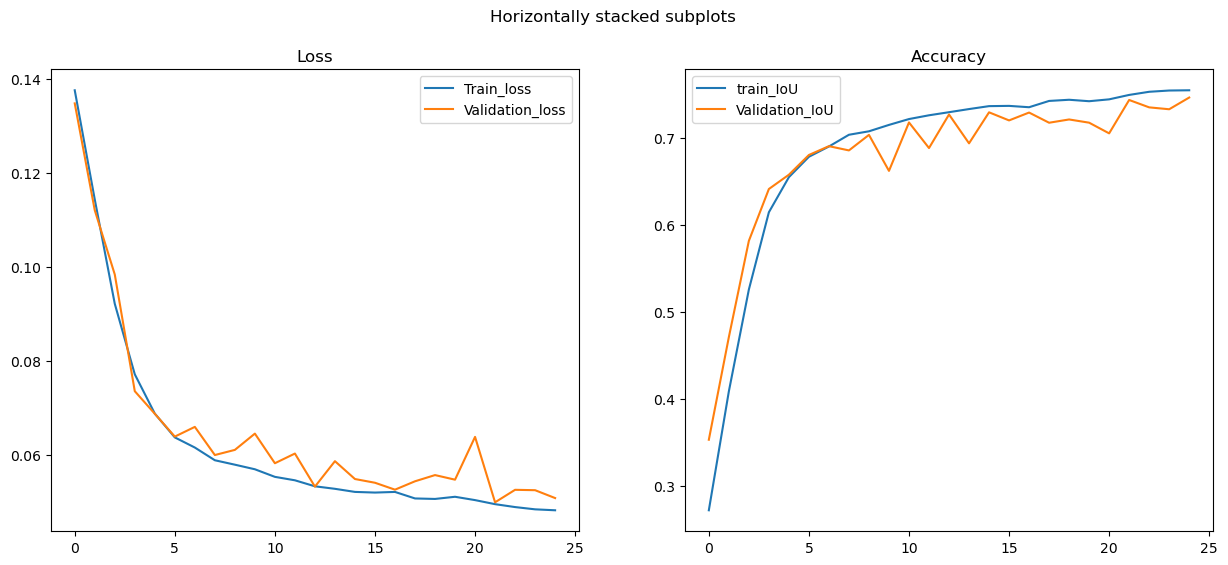

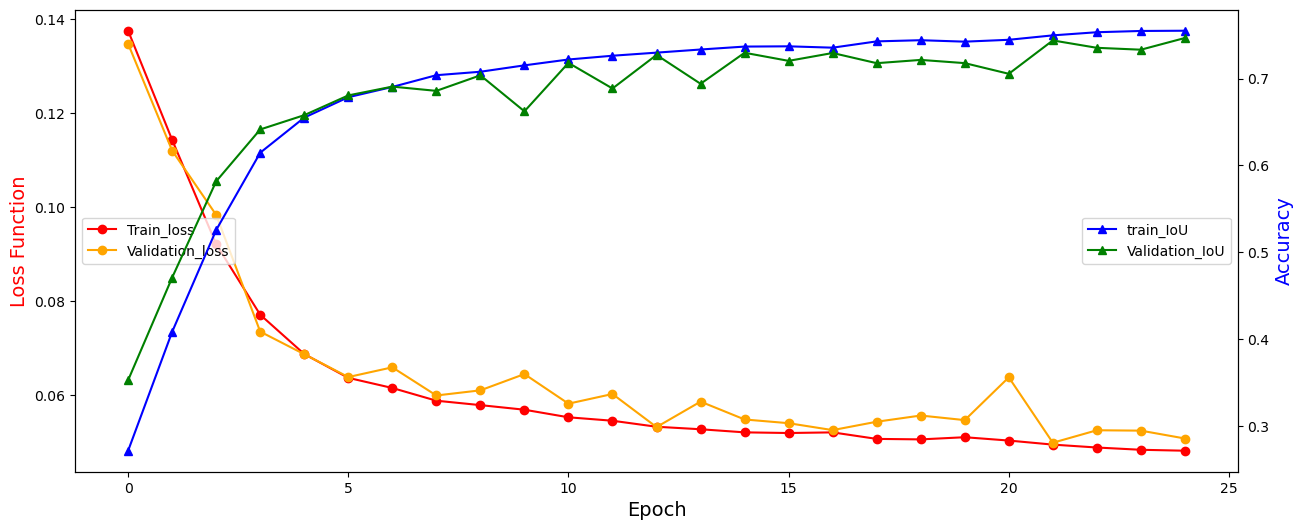

Current time: 12.510 minutes. Time expected till completion: 12.510 minutes

Epoch 26 of 50


100%|██████████| 20/20 [00:01<00:00, 17.99it/s]


train loss:  0.04771123979654577
Val loss:  0.05319810807704926
train IoU:  0.7583257509602441
Val IoU:  0.7443940371274949
Current time: 12.923 minutes. Time expected till completion: 11.929 minutes

Epoch 27 of 50


100%|██████████| 20/20 [00:01<00:00, 18.25it/s]


train loss:  0.048371149371895523
Val loss:  0.05087549239397049
train IoU:  0.7531005909045537
Val IoU:  0.739865842461586
Current time: 13.316 minutes. Time expected till completion: 11.343 minutes

Epoch 28 of 50


100%|██████████| 20/20 [00:01<00:00, 17.95it/s]


train loss:  0.04750069638507234
Val loss:  0.054897554218769073
train IoU:  0.7569821788205041
Val IoU:  0.720873373746872
Current time: 13.710 minutes. Time expected till completion: 10.772 minutes

Epoch 29 of 50


100%|██████████| 20/20 [00:01<00:00, 18.23it/s]


train loss:  0.04804186920324961
Val loss:  0.050566064566373824
train IoU:  0.756633088323805
Val IoU:  0.7514536619186402
Current time: 14.102 minutes. Time expected till completion: 10.212 minutes

Epoch 30 of 50


100%|██████████| 20/20 [00:01<00:00, 17.78it/s]


train loss:  0.04805210369328658
Val loss:  0.04909757897257805
train IoU:  0.755348629090521
Val IoU:  0.7482936233282089
Current time: 14.495 minutes. Time expected till completion: 9.663 minutes

Epoch 31 of 50


100%|██████████| 20/20 [00:01<00:00, 18.25it/s]


train loss:  0.04672549795359373
Val loss:  0.048797822929918765
train IoU:  0.7610479017098745
Val IoU:  0.7500216722488403
Current time: 14.887 minutes. Time expected till completion: 9.124 minutes

Epoch 32 of 50


100%|██████████| 20/20 [00:01<00:00, 17.86it/s]


train loss:  0.046618782977263136
Val loss:  0.049839749932289124
train IoU:  0.7616499821345012
Val IoU:  0.751899141073227
Current time: 15.280 minutes. Time expected till completion: 8.595 minutes

Epoch 33 of 50


100%|██████████| 20/20 [00:01<00:00, 18.33it/s]


train loss:  0.046801103672219645
Val loss:  0.055031100660562514
train IoU:  0.7617926584349738
Val IoU:  0.7197071373462677
Current time: 15.672 minutes. Time expected till completion: 8.073 minutes

Epoch 34 of 50


100%|██████████| 20/20 [00:01<00:00, 17.99it/s]


train loss:  0.046523471580197415
Val loss:  0.05133253969252109
train IoU:  0.7631236152516471
Val IoU:  0.7501838386058808
Current time: 16.065 minutes. Time expected till completion: 7.560 minutes

Epoch 35 of 50


100%|██████████| 20/20 [00:01<00:00, 17.65it/s]


train loss:  0.046599594244940416
Val loss:  0.050910335034132004
train IoU:  0.7627133631043964
Val IoU:  0.7409566551446914
Current time: 16.458 minutes. Time expected till completion: 7.053 minutes

Epoch 36 of 50


100%|██████████| 20/20 [00:01<00:00, 17.53it/s]


train loss:  0.04617302256325881
Val loss:  0.04962370097637177
train IoU:  0.7646108239889144
Val IoU:  0.7435210198163986
Current time: 16.855 minutes. Time expected till completion: 6.555 minutes

Epoch 37 of 50


100%|██████████| 20/20 [00:01<00:00, 18.26it/s]


train loss:  0.046363998452822366
Val loss:  0.049145772494375704
train IoU:  0.7631401396460004
Val IoU:  0.7365116536617279
Current time: 17.251 minutes. Time expected till completion: 6.061 minutes

Epoch 38 of 50


100%|██████████| 20/20 [00:01<00:00, 17.99it/s]


train loss:  0.045829438914855324
Val loss:  0.048873410746455195
train IoU:  0.7671907203065025
Val IoU:  0.7427674323320389
Current time: 17.645 minutes. Time expected till completion: 5.572 minutes

Epoch 39 of 50


100%|██████████| 20/20 [00:01<00:00, 17.11it/s]


train loss:  0.045986417401582005
Val loss:  0.052472200617194174
train IoU:  0.7659228454033534
Val IoU:  0.7324401468038559
Current time: 18.047 minutes. Time expected till completion: 5.090 minutes

Epoch 40 of 50


100%|██████████| 20/20 [00:01<00:00, 17.21it/s]


train loss:  0.045611669619878135
Val loss:  0.04716757144778967
train IoU:  0.7674778153498968
Val IoU:  0.7607116967439651
Current time: 18.444 minutes. Time expected till completion: 4.611 minutes

Epoch 41 of 50


100%|██████████| 20/20 [00:01<00:00, 18.21it/s]


train loss:  0.0449577317159209
Val loss:  0.048419243469834325
train IoU:  0.7699659592575497
Val IoU:  0.7576321423053741
Current time: 18.839 minutes. Time expected till completion: 4.135 minutes

Epoch 42 of 50


100%|██████████| 20/20 [00:01<00:00, 18.23it/s]


train loss:  0.04540093156198661
Val loss:  0.052175666019320485
train IoU:  0.7679696457253562
Val IoU:  0.7196672081947326
Current time: 19.233 minutes. Time expected till completion: 3.663 minutes

Epoch 43 of 50


100%|██████████| 20/20 [00:01<00:00, 18.08it/s]


train loss:  0.045147119576318395
Val loss:  0.050277544930577275
train IoU:  0.7694548716147741
Val IoU:  0.7514080435037613
Current time: 19.627 minutes. Time expected till completion: 3.195 minutes

Epoch 44 of 50


100%|██████████| 20/20 [00:01<00:00, 18.33it/s]


train loss:  0.045216696057468656
Val loss:  0.047923617996275425
train IoU:  0.7675095236963696
Val IoU:  0.7506662219762802
Current time: 20.020 minutes. Time expected till completion: 2.730 minutes

Epoch 45 of 50


100%|██████████| 20/20 [00:01<00:00, 18.07it/s]


train loss:  0.0448862577892012
Val loss:  0.04796830601990223
train IoU:  0.7704614788293839
Val IoU:  0.7587454825639725
Current time: 20.415 minutes. Time expected till completion: 2.268 minutes

Epoch 46 of 50


100%|██████████| 20/20 [00:01<00:00, 18.30it/s]


train loss:  0.0451761890306241
Val loss:  0.05173408966511488
train IoU:  0.7692508548498154
Val IoU:  0.7229694485664367
Current time: 20.810 minutes. Time expected till completion: 1.810 minutes

Epoch 47 of 50


100%|██████████| 20/20 [00:01<00:00, 17.30it/s]


train loss:  0.04437766671180725
Val loss:  0.05109142456203699
train IoU:  0.7724569459756215
Val IoU:  0.7464069932699203
Current time: 21.206 minutes. Time expected till completion: 1.354 minutes

Epoch 48 of 50


100%|██████████| 20/20 [00:01<00:00, 18.30it/s]


train loss:  0.04400602457010084
Val loss:  0.04813625831156969
train IoU:  0.7750758323404524
Val IoU:  0.7620941460132599
Current time: 21.600 minutes. Time expected till completion: 0.900 minutes

Epoch 49 of 50


100%|██████████| 20/20 [00:01<00:00, 17.58it/s]


train loss:  0.04436252780465616
Val loss:  0.04626413621008396
train IoU:  0.7723227431376775
Val IoU:  0.7646954476833343
Current time: 21.995 minutes. Time expected till completion: 0.449 minutes

Epoch 50 of 50


100%|██████████| 20/20 [00:01<00:00, 18.18it/s]


train loss:  0.04421244166377518
Val loss:  0.04944493286311626
train IoU:  0.7736110611094369
Val IoU:  0.7547556102275849
Saving model checkpoint


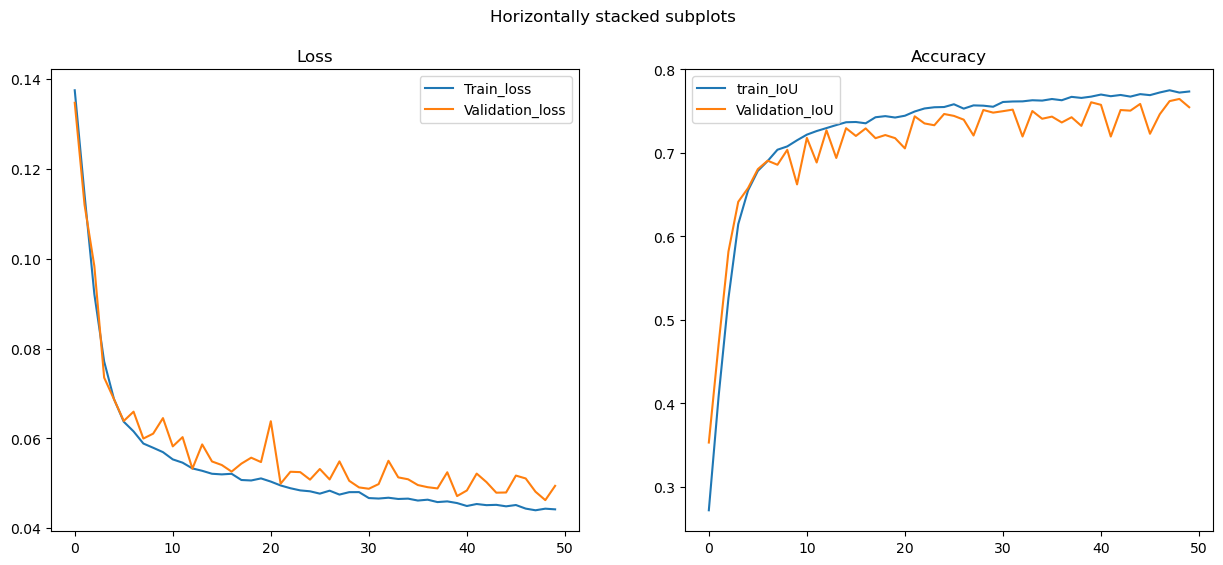

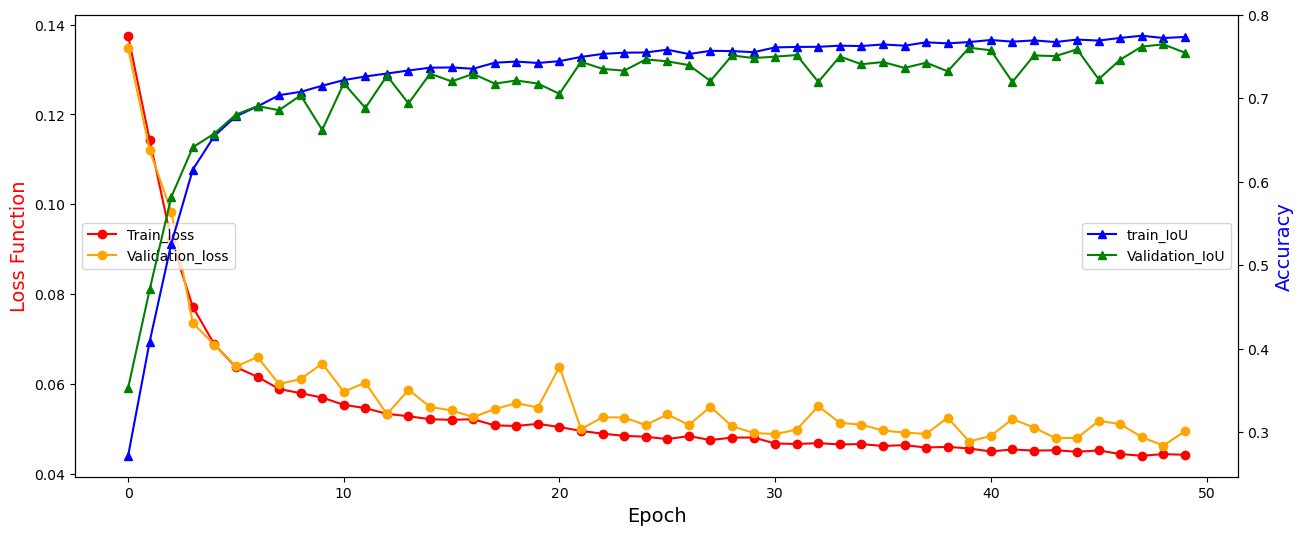

Current time: 22.407 minutes. Time expected till completion: 0.000 minutes
Finished training in: 22.409 minutes


In [15]:

# Main
train_loss, val_loss = [], []
train_IoU, val_IoU = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_IoU = dd["train_IoU"].tolist()
        val_IoU = dd["val_IoU"].tolist()
        
# count time
start = time.time()
#PyTorch - Training the Model
for epoch in range(epoch_check, epochs):
    print()
    # Print current epoch
    print(f"Epoch {epoch + 1} of {epochs}")
    
    # Train model
    modelpy.train()
    running_loss=0
    total=0
    accumulatedIoU=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[2].to(device)# use the gpu
        
        #create the output from the CNN base on the give batch images
        out = modelpy(images)
        # count the loss function 
        loss = criterion(out, labels)
        
        ######################
        optim.zero_grad()
        ######################
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        
        
        # add new value to the main loss
        running_loss += loss.item()
        
        # calculate IoU
        predictions = torch.argmax(out, dim=1)
        total += labels.size(0)
        
        iioouu = calculate_IoU(predictions, labels)
        accumulatedIoU += iioouu.sum().item()
    
    train_epoch_loss = running_loss/len(train_loader.dataset)
    train_epoch_IoU = accumulatedIoU/total
    
    
    modelpy.eval()
    running_loss = 0.0
    total=0
    accumulatedIoU=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            labels = data[2].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion(outputs, labels)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate IoU
            predictions = torch.argmax(outputs, dim=1)
            total += labels.size(0)

            iioouu = calculate_IoU(predictions, labels)
            accumulatedIoU += iioouu.sum().item()
           
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_IoU = accumulatedIoU/total

    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train IoU: ", train_epoch_IoU)
    print("Val IoU: ", val_epoch_IoU)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_IoU.append(train_epoch_IoU)
    val_IoU.append(val_epoch_IoU)
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_IoU, val_IoU, path = model_checkpoints + "metrics_losss_accuracy.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt_"+str(epoch+1)+".pth")
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_IoU, val_IoU)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

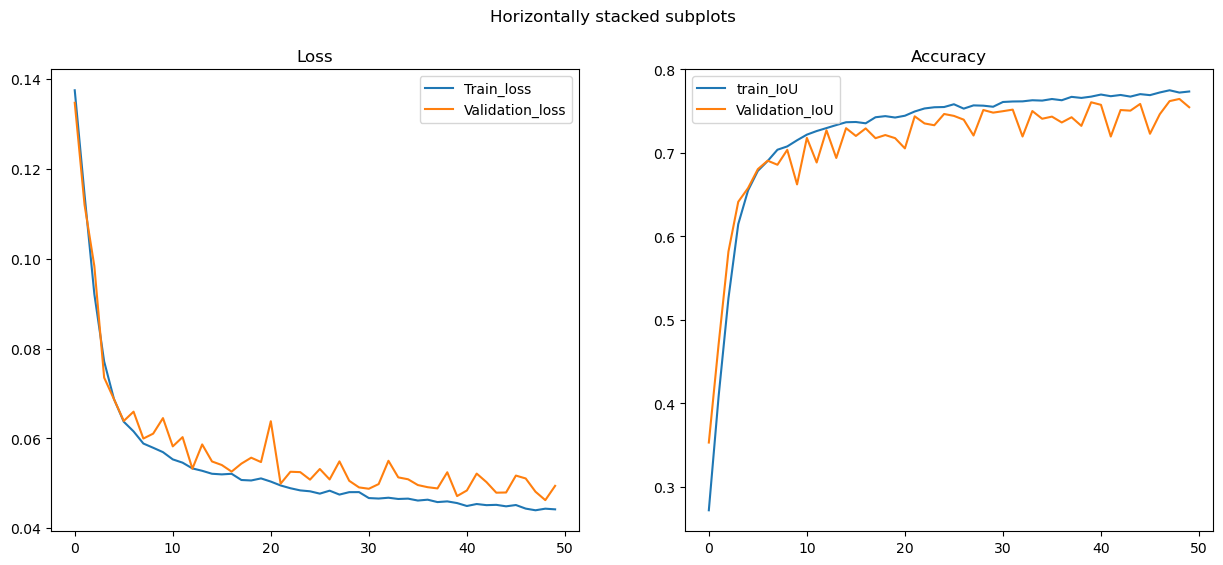

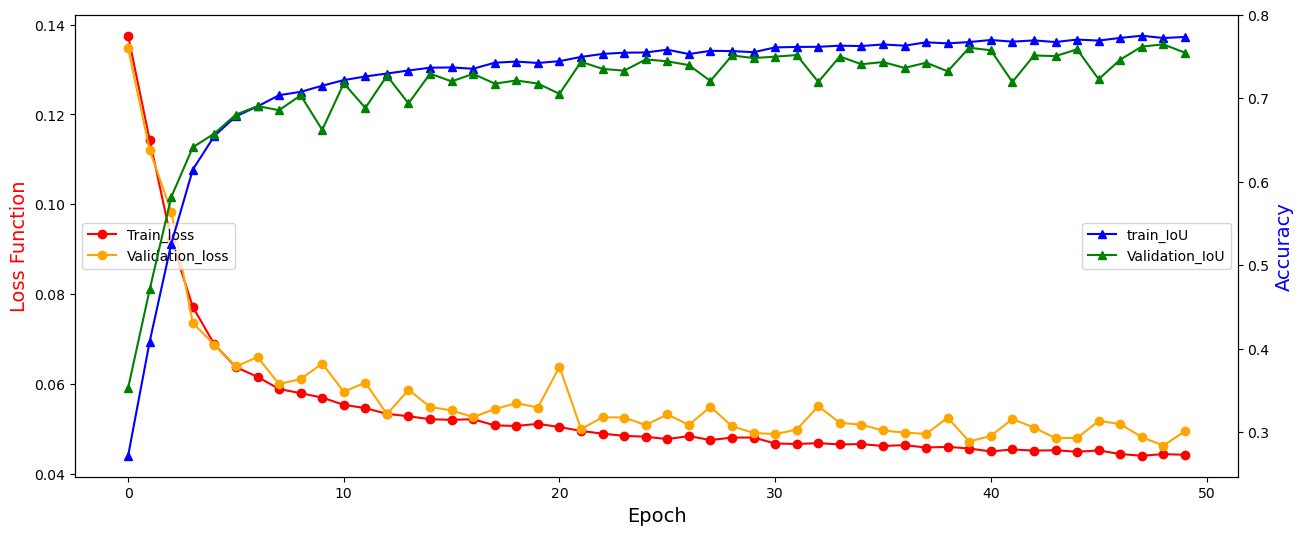

In [16]:
plot_loss_accuracy(train_loss, val_loss, train_IoU, val_IoU)

## Save Model

In [17]:
# Save Model
NAME = "model_1.pt"

torch.save(modelpy.state_dict(), model_checkpoints+NAME)

## Load Model

In [18]:

# Load the model
NAME = "model_1.pt"
modelpy.load_state_dict(torch.load(model_checkpoints+NAME, map_location=device))


<All keys matched successfully>

# 3.Evaluate your model using the test images

In [19]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [20]:
test_data, test_mask, test_labels = import_folder_dataset(root_path = test_data_path, resized_side = img_size)#(1024,1024)


print("Dim of Data: ", test_data.shape)
print("Dim of Mask: ", test_mask.shape)
print("Dim of Lables: ", test_labels.shape)

100%|██████████| 200/200 [00:17<00:00, 11.45it/s]

Dim of Data:  (200, 256, 256, 3)
Dim of Mask:  (200, 256, 256, 3)
Dim of Lables:  (200, 256, 256)


In [21]:
# Create the dataset object
test_Dataset = Data(test_data, test_mask, test_labels, img_transform) 


print("Test len: ",len(test_Dataset))

Test len:  200


In [22]:
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,
    shuffle=False
    )

def calculate_Dice(pred, label):
    
    overlap = torch.logical_and(pred, label)
    denominator = torch.sum(pred, dim = [-1,-2] ) + torch.sum(label, dim = [-1,-2] )
    
    
    iou = torch.sum(overlap, dim = [-1,-2] ) / denominator
    
    return 2*iou

def make_predictions(loader, model, invTransforamtion, device):
    model.eval()

    image_list = []
    real_mask = []
    predictions_list = []
    accumulatedIoU = 0
    accumulatedDice = 0
    total = 0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(loader), total=len(loader)):

            # Use model_bbox model to get the new cropped images basen on CAM
            images = data[0].to(device)# use the gpu
            labels = data[2].to(device)# use the gpu

            outputs = model(images)

            # calculate IoU
            predictions = torch.argmax(outputs, dim=1)
            total += labels.size(0)

            iioouu = calculate_IoU(predictions, labels)
            accumulatedIoU += iioouu.sum().item()
            
            
            dicee = calculate_Dice(predictions, labels)
            accumulatedDice += dicee.sum().item()
            
            # Invert the img transformation, and reorder to an Img
            im = np.moveaxis(invTransforamtion(data[0][0]).numpy(), 0, -1)
            
            image_list.append(im)
            real_mask.append(data[1][0].numpy())
            predictions_list.append(predictions[0].detach().cpu().numpy())

    mean_IoU = accumulatedIoU/total
    mean_dice = accumulatedDice/total
    return(mean_IoU, mean_dice, image_list, real_mask, predictions_list)

In [25]:

mean_IoU, mean_dice, image_list, mask_list, predictions_list = make_predictions(loader = test_loader, 
                                                                     model = modelpy, 
                                                                     invTransforamtion = invTrans,
                                                                     device = device)
print(f'Average IoU of the model on the 200 Test dataset instances: {100 * mean_IoU}%')
print(f'Average Dice of the model on the 200 Test dataset instances: {100 * mean_dice}%')

100%|██████████| 200/200 [00:03<00:00, 50.86it/s]

Average IoU of the model on the 200 Test dataset instances: 76.94248725473881%
Average Dice of the model on the 200 Test dataset instances: 86.5879057943821%


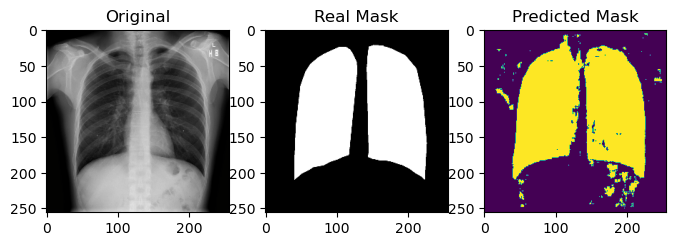

In [26]:
image_to_plot = 10

real_image = image_list[image_to_plot]
real_mask = mask_list[image_to_plot]
pred_mask = predictions_list[image_to_plot]

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(8,8))
ax1.imshow(real_image)
ax1.title.set_text("Original")
ax2.imshow(real_mask)
ax2.title.set_text("Real Mask")
ax3.imshow(pred_mask)
ax3.title.set_text("Predicted Mask")
plt.show()

# 4. Your IoU score should be higher than 0.82

In [28]:
print(f'Average IoU of the model on the 200 Test dataset instances: {100 * mean_IoU}%')

Average IoU of the model on the 200 Test dataset instances: 76.94248725473881%


In [27]:
print(f'Average Dice of the model on the 200 Test dataset instances: {100 * mean_dice}%')

Average Dice of the model on the 200 Test dataset instances: 86.5879057943821%


# 5. Write a two-page report using LaTex and upload your paper to ResearchGate or Arxiv. 
